# PCA Calculations

In this notebook, I create all of the PCA variables. I also compare measures of "treatment" in terms of how many units are treated.

#### Import Line

In [1]:
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon
from simpledbf import Dbf5
import numpy as np

%matplotlib inline
with open("data_dir.txt") as f:
    data_dir = f.read()

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


## Prep Data

In [3]:
# County shapefile
counties = gp.read_file(data_dir + 'spatial_data/tmean_total.shp')
counties = counties[counties.year==1920]
counties['FIPS'] = counties['FIPS'].astype(int)

# Get rid of these two extinct counties
counties = counties.loc[~((counties.ICPSRNAM=='MILTON')&(counties.STATENAM=='Georgia'))]
counties = counties.loc[~((counties.ICPSRNAM=='CAMPBELL')&(counties.STATENAM=='Georgia'))]

# List of each counties in PCA coverage area.
coverage = pd.read_csv(data_dir+'pca_data/county_list.csv')
coverage['FIPS_PCA'] = coverage['pca_id'].apply(lambda x: x.split("_")[0]).astype(int)

# The points for each PCA.
PCAs = gp.read_file(data_dir + "pca_data/pca_eqarea.shp")
PCAs = PCAs.rename(columns={"cityid":"pca_id",\
                            "pca_citi_1":"state",\
                            "pca_citi_2":"county",\
                            "pca_citi_3":"city"})

PCAs.loc[PCAs['pca_id'] =="48207_stam","pca_id"] = "48253_stam" 
PCAs.loc[PCAs['pca_id'] =="48207_stam","FIPS"] = 48253 
coverage['pca_id'] = coverage['pca_id'].replace("48207_stam","48253_stam")

# Filling in some missing IDs.
missing_ids = ["24011_dent","34011_brid","34005_moor","34023_newb","34027_morr","42091_norr","42077_alle"]
PCAs.loc[:6,"pca_id"] = missing_ids

PCAs['FIPS'] = (PCAs['SFIPS']+PCAs['CFIPS'])

# Missing one city, correcting here by adding it in.
city_file = data_dir + "pca_data/ci08au12.shp"
Cities = gp.read_file(city_file)
Cities = Cities.set_crs(epsg=4326)
Cities = Cities.to_crs(epsg=2163)
Cities = Cities.rename(columns={"cityid":"pca_id"})

pcalist = pd.read_csv(data_dir+"pca_data/pca_list.csv")
pca_cities = Cities.merge(pcalist,on="pca_id",how='right')
bennet = pca_cities[pca_cities['city'] =="Bennettsville"].drop_duplicates()
PCAs = pd.concat([PCAs,bennet],axis=0)

# Finding whether the PCA is in the county.
counties = counties.merge(coverage[['FIPS_PCA']].drop_duplicates(),left_on="FIPS",right_on="FIPS_PCA",how='left')
counties['PCA'] = (~pd.isnull(counties.FIPS_PCA)).astype(int)
counties.drop("FIPS_PCA",axis=1,inplace=True)

# Measure latitude and longitude coordinates (in WGS 84)
counties['lat'] = counties.to_crs("EPSG:4326").centroid.x
counties['lon'] = counties.to_crs("EPSG:4326").centroid.y

# Merging PCA id in.
counties = counties.merge(coverage[['pca_id','FIPS']].drop_duplicates(),how='left')

# Coverage areas shapefile
coverage_areas = counties.dissolve("pca_id")
area_geom = coverage_areas.pop("geometry")
area_geom = area_geom.apply(lambda x: list(x) if isinstance(x, MultiPolygon) else x).explode()
coverage_areas = coverage_areas.join(area_geom, how='inner')

<ipython-input-3-bca0df015700>:49: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties['lat'] = counties.to_crs("EPSG:4326").centroid.x
<ipython-input-3-bca0df015700>:50: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties['lon'] = counties.to_crs("EPSG:4326").centroid.y


Calculate Distance

In [7]:
PCAs_points = PCAs[['pca_id','geometry']].drop_duplicates().set_index("pca_id")['geometry']
counties = counties[~pd.isnull(counties['pca_id'])].set_index("FIPS")

D = []
for pca in counties['pca_id'].unique():
    D += [counties[counties['pca_id']==pca].centroid.distance(PCAs_points[pca])/1000]
    
D = pd.concat(D,axis=0).reset_index()

D.columns = ["FIPS","pca_km"]

counties = counties.reset_index().merge(D).drop_duplicates()

counties['pca_km_cat'] = pd.cut(counties['pca_km'],[0,30,45,60,100,1000])
counties['pca_km_cat_no'] = counties['pca_km_cat'].cat.codes

In [8]:
def closest_distance(x):
    return PCAs.geometry.distance(x).min()/1000

CD = counties.set_index("FIPS").centroid.apply(closest_distance)

CD = CD.reset_index()
CD.columns = ["FIPS","pca_km_closest"] 

counties = counties.merge(CD,how='left')

## PCA Adjacent

Here we will identify counties that are adjacent to a PCA county.

Here are some example states:

C:\Users\jhtchns2\.conda\envs\farm_credit\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\jhtchns2\.conda\envs\farm_credit\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
No handles with labels found to put in legend.


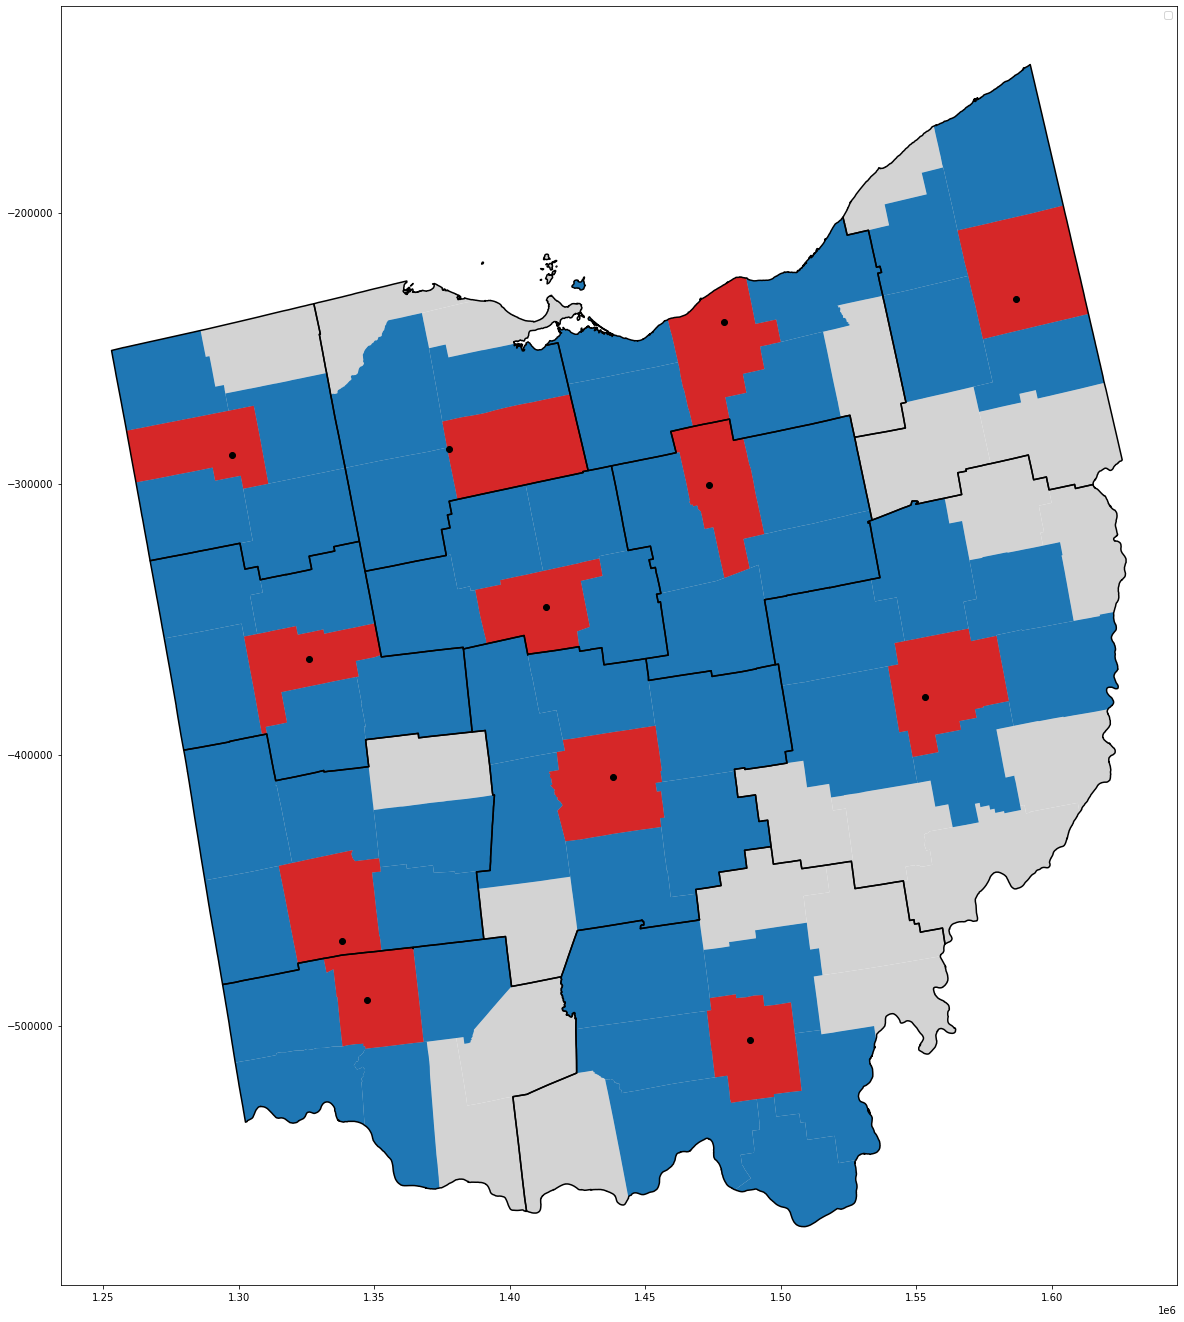

In [9]:
# Define state
OHIO = counties[counties.STATENAM=="Ohio"]

# Find PCA county
OHIO_PCAs = OHIO[OHIO['PCA']==1]

# Find adjacent counties
OHIO['PCA_adj'] = OHIO['PCA']

# Uses "intersects" operation from Geopandas
for pca in OHIO_PCAs.geometry:
    OHIO.loc[OHIO.geometry.intersects(pca),"PCA_adj"] = 1
    
# Plot it:
f,a = plt.subplots(figsize=(20,40))
OHIO.plot(ax=a,color='lightgray')
OHIO[OHIO['PCA_adj']==1].plot(ax=a)
OHIO_PCAs.plot(ax=a,color="C3",label='PCA Present')
coverage_areas[coverage_areas['STATENAM']=="Ohio"].exterior.plot(ax=a,color='black')
PCAs[PCAs.state=="Ohio"].plot(color="black",ax=a)
plt.legend()

C:\Users\jhtchns2\.conda\envs\farm_credit\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\jhtchns2\.conda\envs\farm_credit\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
No handles with labels found to put in legend.


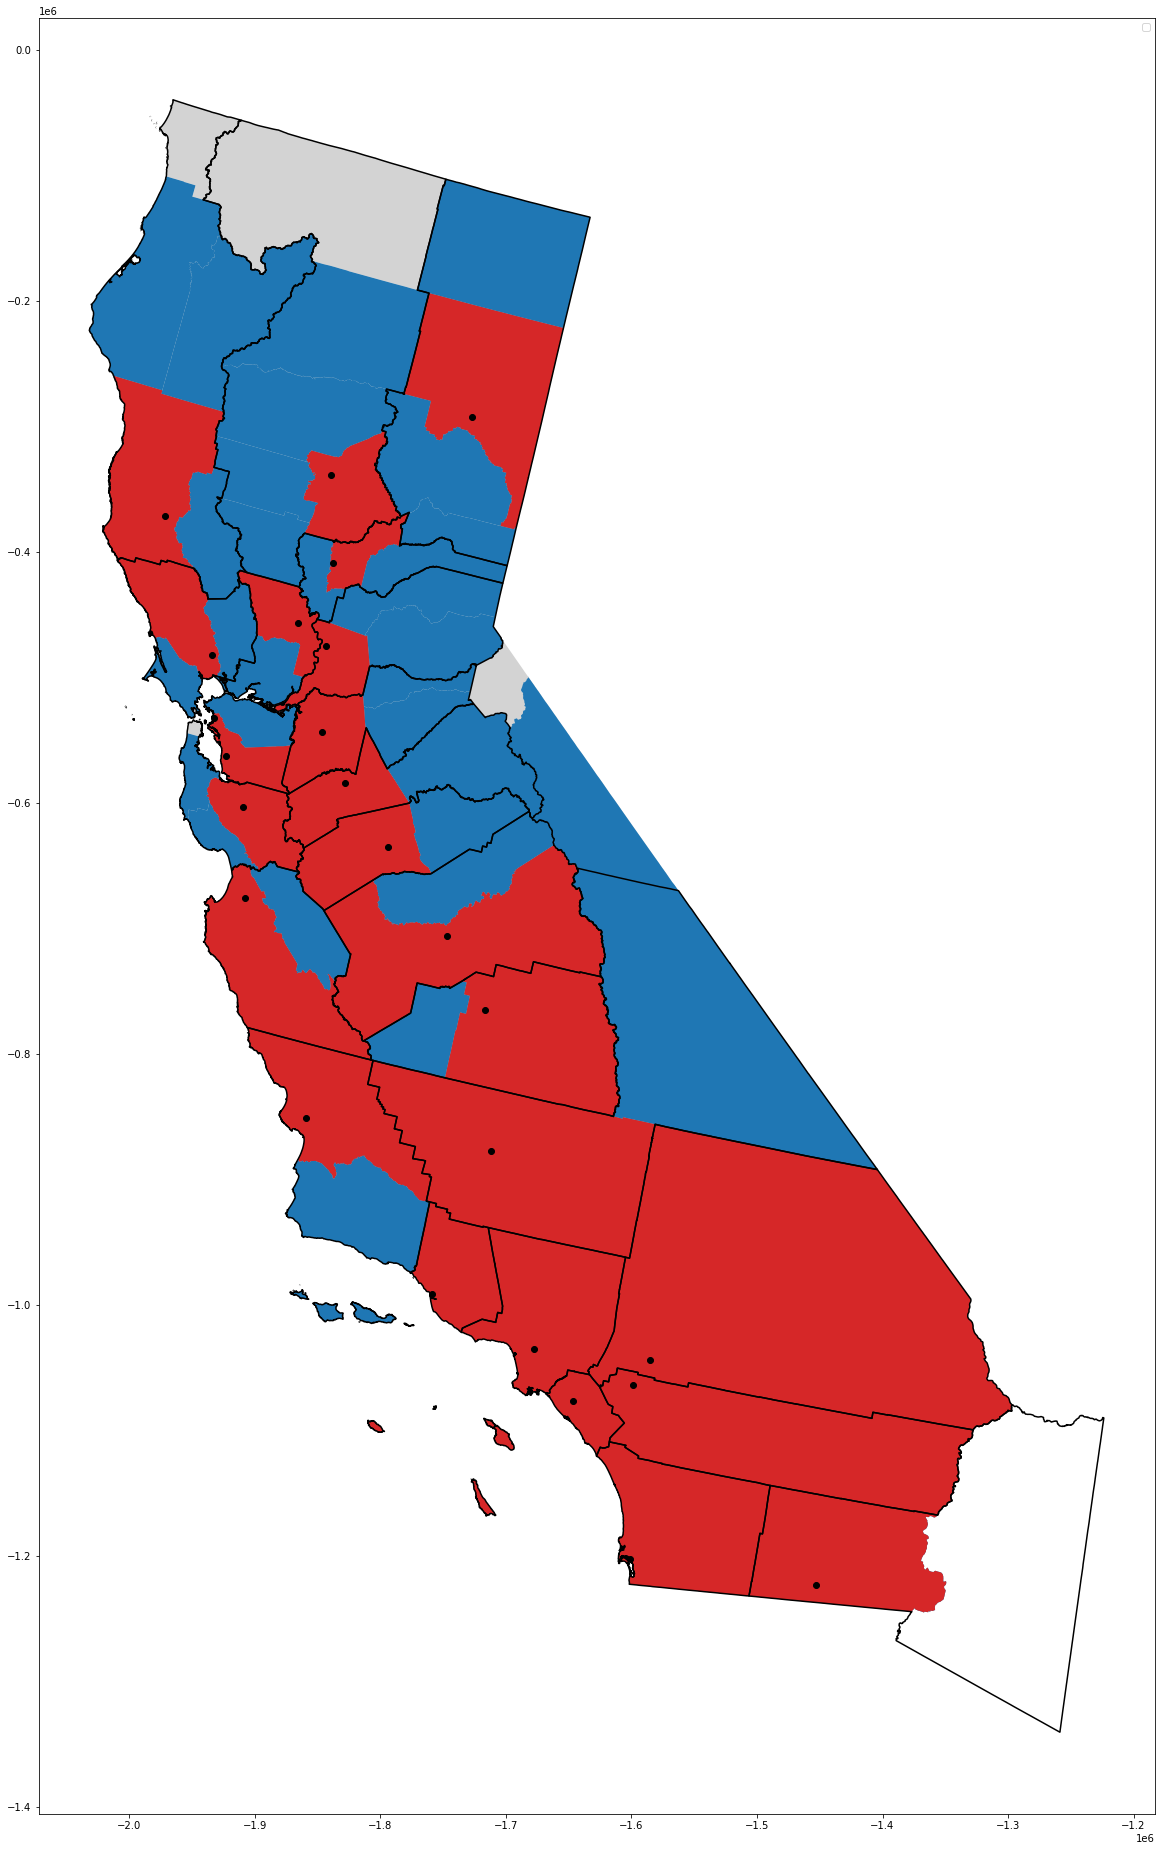

In [10]:
CA = counties[counties.STATENAM=="California"]

CA_PCAs = CA[CA['PCA']==1]

CA['PCA_adj'] = CA['PCA']

for pca in CA_PCAs.geometry:
    CA.loc[CA.geometry.intersects(pca),"PCA_adj"] = 1
    
f,a = plt.subplots(figsize=(20,40))
CA.plot(ax=a,color='lightgray')
CA[CA['PCA_adj']==1].plot(ax=a)
CA_PCAs.plot(ax=a,color="C3",label='PCA Present')
coverage_areas[coverage_areas['STATENAM']=="California"].exterior.plot(ax=a,color='black')
PCAs[PCAs.state=="California"].plot(color="black",ax=a)
plt.legend()

C:\Users\jhtchns2\.conda\envs\farm_credit\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\jhtchns2\.conda\envs\farm_credit\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
No handles with labels found to put in legend.


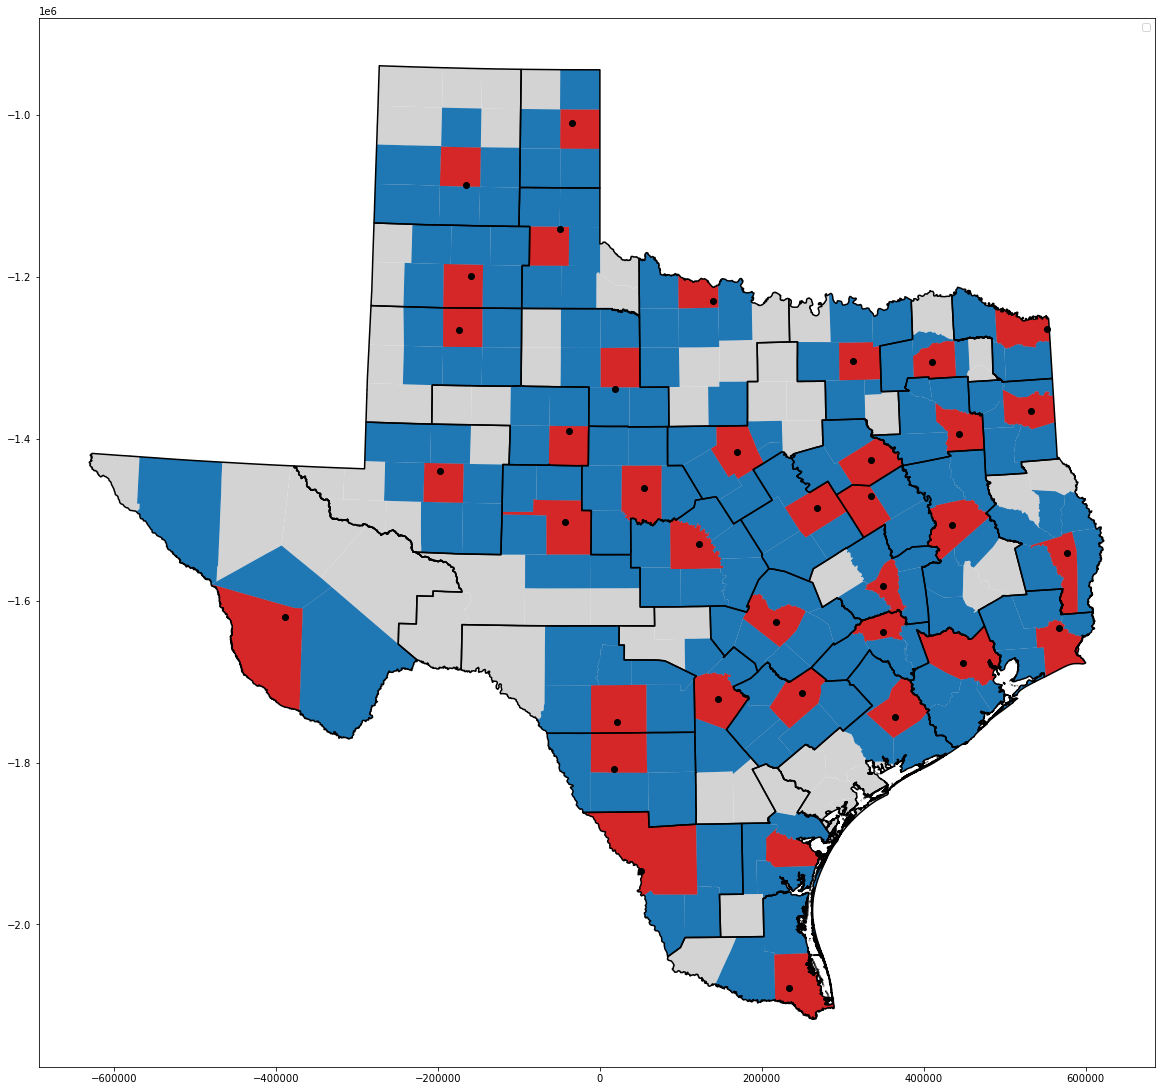

In [11]:
TX = counties[counties.STATENAM=="Texas"]

TX_PCAs = TX[TX['PCA']==1]

TX['PCA_adj'] = TX['PCA']

for pca in TX_PCAs.geometry:
    TX.loc[TX.geometry.intersects(pca),"PCA_adj"] = 1
    
f,a = plt.subplots(figsize=(20,40))
TX.plot(ax=a,color='lightgray')
TX[TX['PCA_adj']==1].plot(ax=a)
TX_PCAs.plot(ax=a,color="C3",label='PCA Present')
coverage_areas[coverage_areas['STATENAM']=="Texas"].exterior.plot(ax=a,color='black')
PCAs[PCAs.state=="Texas"].plot(color="black",ax=a)
plt.legend()

Now for the whole country:

In [12]:
counties['PCA_adj'] = counties['PCA']

for i,row in counties[counties['PCA']==1].iterrows():
    counties.loc[counties.geometry.intersects(row.geometry),"PCA_adj"] = 1

<AxesSubplot:>

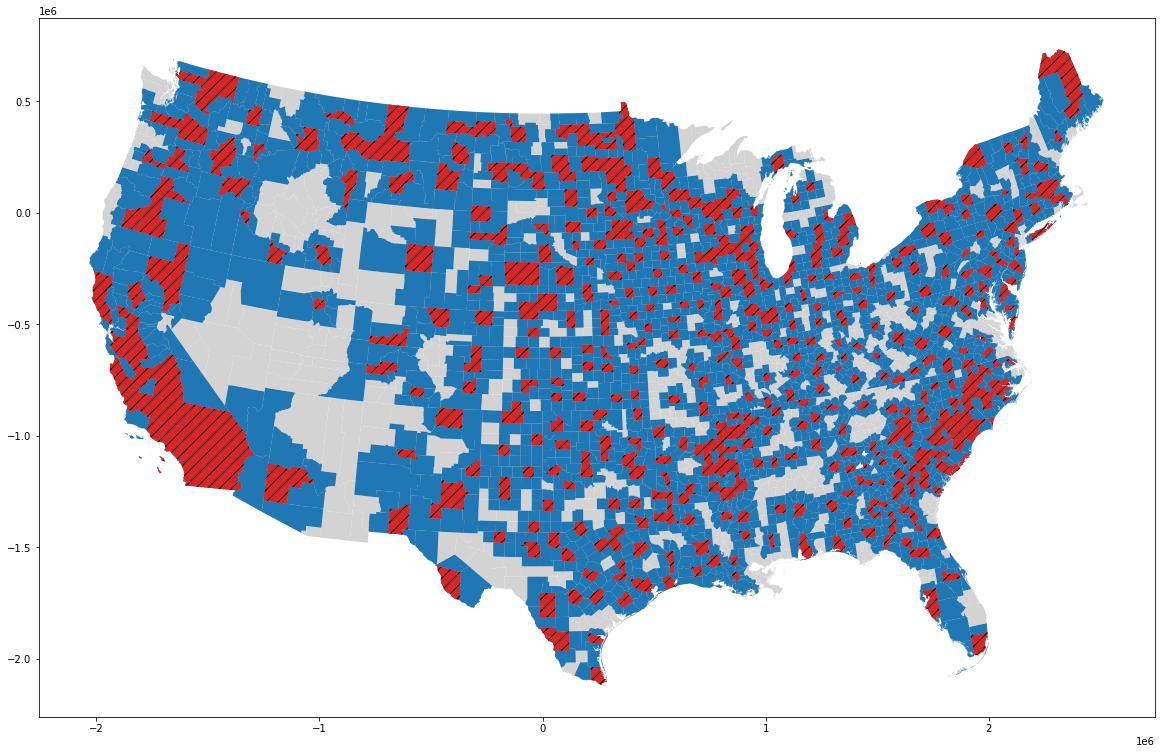

In [9]:
f,a = plt.subplots(figsize=(20,40))
counties.plot(ax=a,color="lightgray")
counties[counties['PCA_adj']==1].plot(ax=a,color="C0")
counties[counties['PCA']==1].plot(ax=a,color="C3",hatch="//")

<AxesSubplot:>

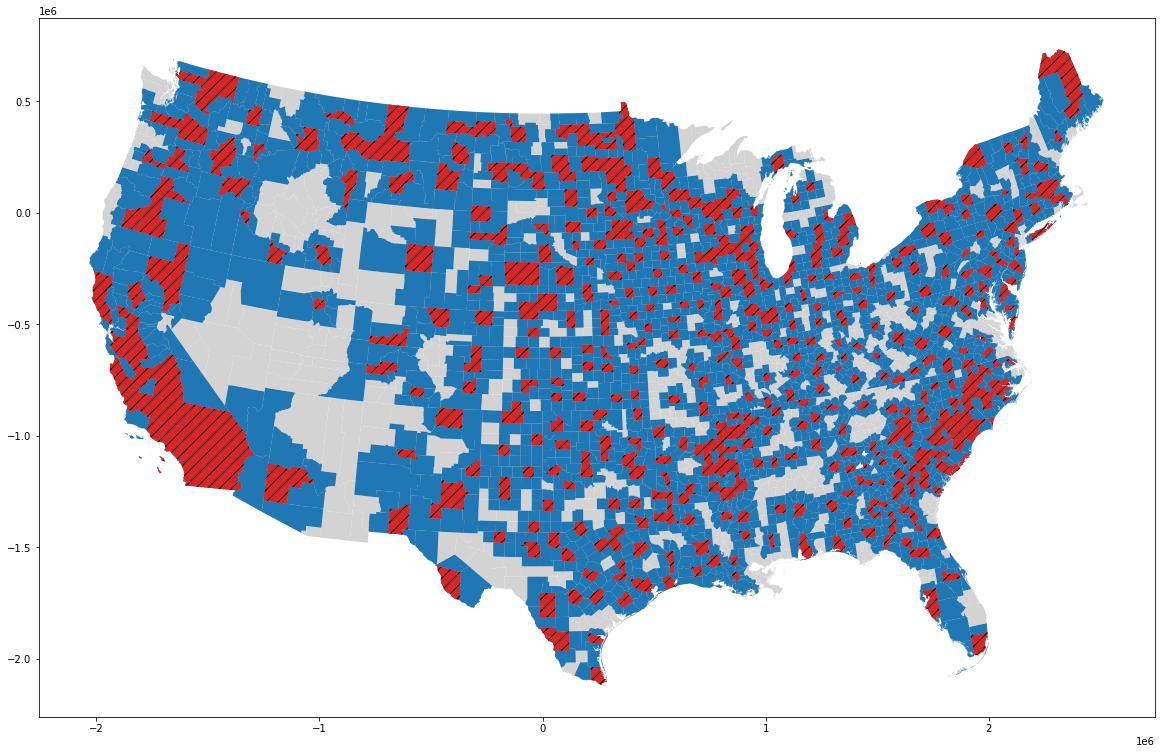

In [13]:
f,a = plt.subplots(figsize=(20,40))
counties.plot(ax=a,color="lightgray")
counties[counties['PCA_adj']==1].plot(ax=a,color="C0")
counties[counties['PCA']==1].plot(ax=a,color="C3",hatch="//")

## PCA Adjacent within Coverage Area

Here we only consider a county "adjacent" if it is adjacent AND within the coverage area.

C:\Users\jhtchns2\.conda\envs\farm_credit\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\jhtchns2\.conda\envs\farm_credit\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Text(0.5, 1.0, 'Adjacent within Area')

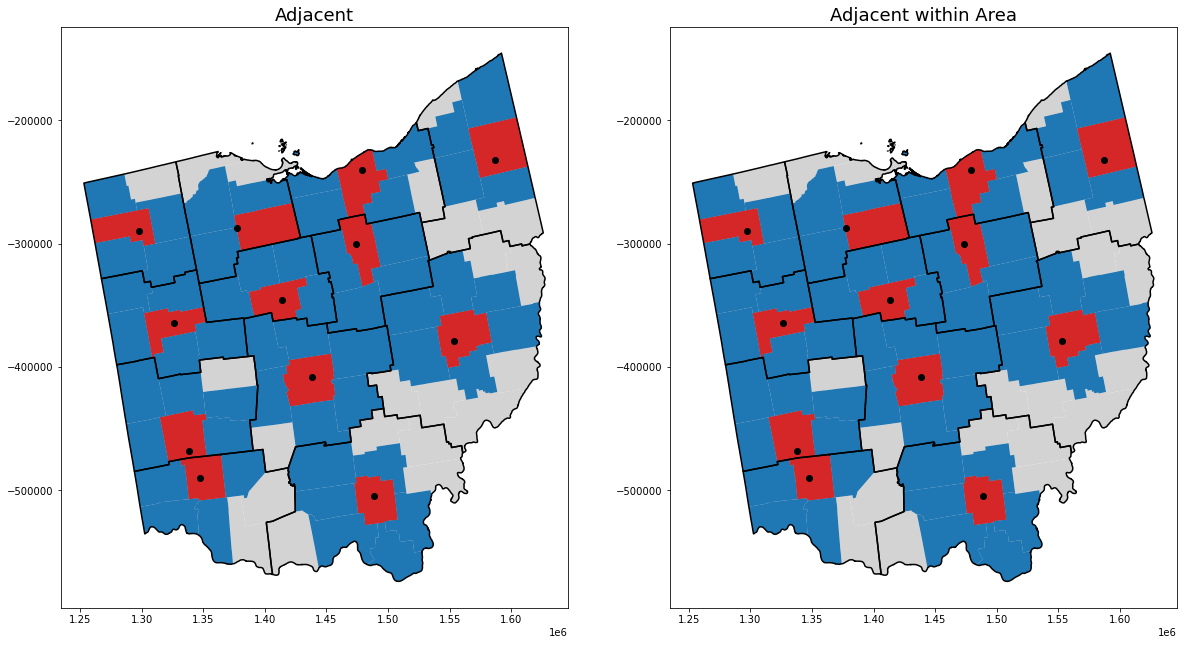

In [14]:
OHIO['PCA_area_adj'] = OHIO['PCA']

for group in OHIO.pca_id.unique():
    for i,row in OHIO[(OHIO['PCA']==1)&(OHIO.pca_id==group)].iterrows():
        OHIO.loc[(OHIO.geometry.intersects(row.geometry))&\
                     (OHIO.pca_id==group),"PCA_area_adj"] = 1
    
# Plot it:
f,a = plt.subplots(1,2,figsize=(20,40))

OHIO.plot(ax=a[0],color='lightgray')
OHIO[OHIO['PCA_adj']==1].plot(ax=a[0])
OHIO_PCAs.plot(ax=a[0],color="C3",label='PCA Present')
coverage_areas[coverage_areas['STATENAM']=="Ohio"].exterior.plot(ax=a[0],color='black')
PCAs[PCAs.state=="Ohio"].plot(color="black",ax=a[0])
a[0].set_title("Adjacent",fontsize=18)

OHIO.plot(ax=a[1],color='lightgray')
OHIO[OHIO['PCA_area_adj']==1].plot(ax=a[1])
OHIO_PCAs.plot(ax=a[1],color="C3",label='PCA Present')
coverage_areas[coverage_areas['STATENAM']=="Ohio"].exterior.plot(ax=a[1],color='black')
PCAs[PCAs.state=="Ohio"].plot(color="black",ax=a[1])
a[1].set_title("Adjacent within Area",fontsize=18)

C:\Users\jhtchns2\.conda\envs\farm_credit\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\jhtchns2\.conda\envs\farm_credit\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Text(0.5, 1.0, 'Adjacent within Area')

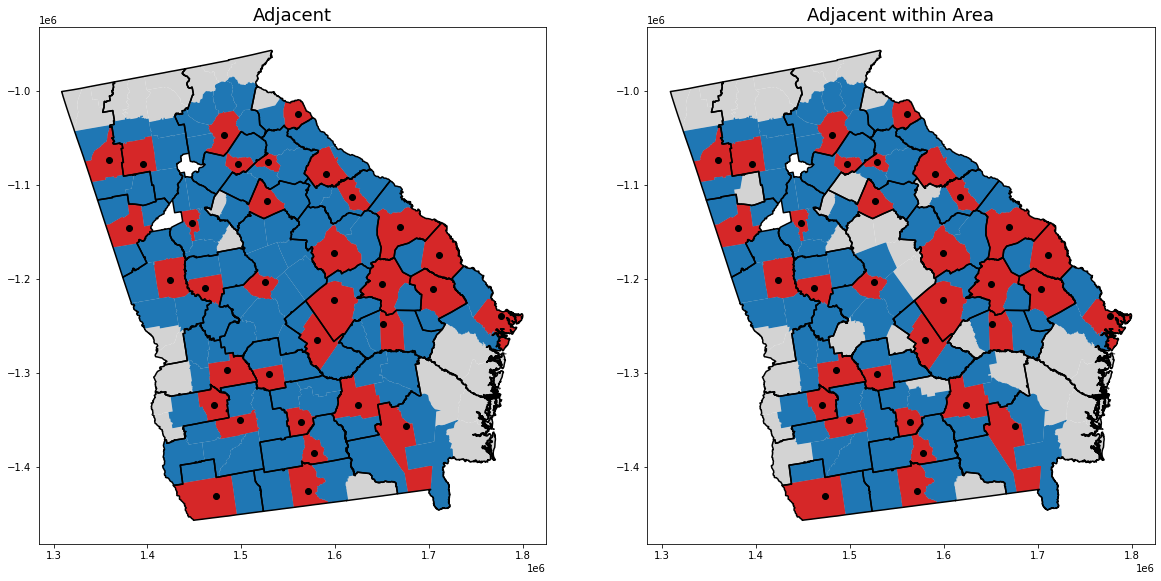

In [15]:
GA = counties[counties.STATENAM=="Georgia"]

GA_PCAs = GA[GA['PCA']==1]

GA['PCA_adj'] = GA['PCA']

for pca in GA_PCAs.geometry:
    GA.loc[GA.geometry.intersects(pca),"PCA_adj"] = 1

GA['PCA_area_adj'] = GA['PCA']

for group in GA.pca_id.unique():
    for i,row in GA[(GA['PCA']==1)&(GA.pca_id==group)].iterrows():
        GA.loc[(GA.geometry.intersects(row.geometry))&\
                     (GA.pca_id==group),"PCA_area_adj"] = 1
    
# Plot it:
f,a = plt.subplots(1,2,figsize=(20,40))

GA.plot(ax=a[0],color='lightgray')
GA[GA['PCA_adj']==1].plot(ax=a[0])
GA_PCAs.plot(ax=a[0],color="C3",label='PCA Present')
coverage_areas[coverage_areas['STATENAM']=="Georgia"].exterior.plot(ax=a[0],color='black')
PCAs[PCAs.state=="Georgia"].plot(color="black",ax=a[0])
a[0].set_title("Adjacent",fontsize=18)

GA.plot(ax=a[1],color='lightgray')
GA[GA['PCA_area_adj']==1].plot(ax=a[1])
GA_PCAs.plot(ax=a[1],color="C3",label='PCA Present')
coverage_areas[coverage_areas['STATENAM']=="Georgia"].exterior.plot(ax=a[1],color='black')
PCAs[PCAs.state=="Georgia"].plot(color="black",ax=a[1])
a[1].set_title("Adjacent within Area",fontsize=18)

C:\Users\jhtchns2\.conda\envs\farm_credit\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\jhtchns2\.conda\envs\farm_credit\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Text(0.5, 1.0, 'Adjacent within Area')

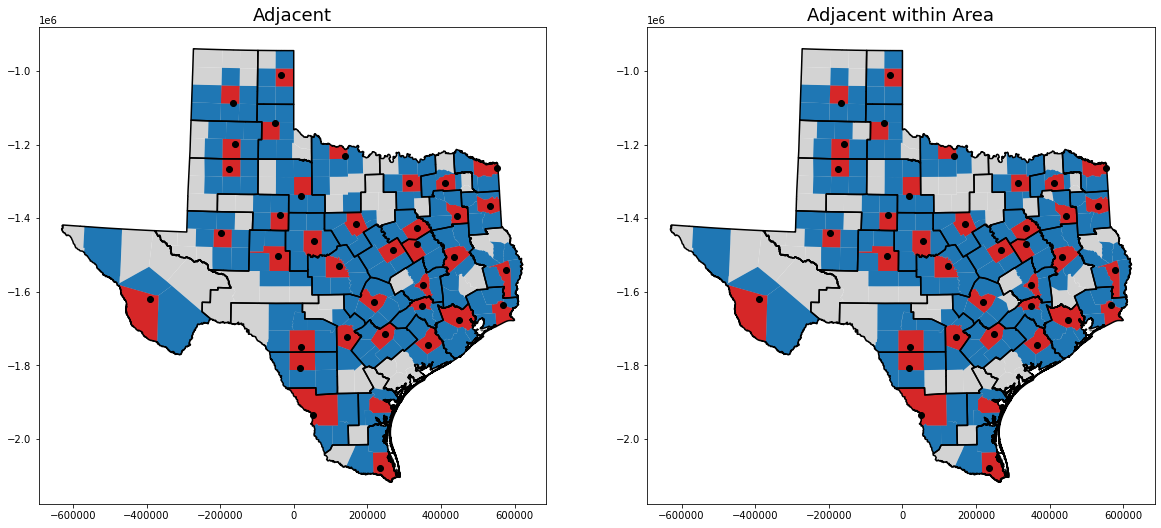

In [16]:
TX['PCA_area_adj'] = TX['PCA']

for group in TX.pca_id.unique():
    for i,row in TX[(TX['PCA']==1)&(TX.pca_id==group)].iterrows():
        TX.loc[(TX.geometry.intersects(row.geometry))&\
                     (TX.pca_id==group),"PCA_area_adj"] = 1
    
# Plot it:
f,a = plt.subplots(1,2,figsize=(20,40))

TX.plot(ax=a[0],color='lightgray')
TX[TX['PCA_adj']==1].plot(ax=a[0])
TX_PCAs.plot(ax=a[0],color="C3",label='PCA Present')
coverage_areas[coverage_areas['STATENAM']=="Texas"].exterior.plot(ax=a[0],color='black')
PCAs[PCAs.state=="Texas"].plot(color="black",ax=a[0])
a[0].set_title("Adjacent",fontsize=18)

TX.plot(ax=a[1],color='lightgray')
TX[TX['PCA_area_adj']==1].plot(ax=a[1])
TX_PCAs.plot(ax=a[1],color="C3",label='PCA Present')
coverage_areas[coverage_areas['STATENAM']=="Texas"].exterior.plot(ax=a[1],color='black')
PCAs[PCAs.state=="Texas"].plot(color="black",ax=a[1])
a[1].set_title("Adjacent within Area",fontsize=18)

In [17]:
counties['PCA_area_adj'] = counties['PCA']

for group in counties.pca_id.unique():
    for i,row in counties[(counties['PCA']==1)&(counties.pca_id==group)].iterrows():
        counties.loc[(counties.geometry.intersects(row.geometry))&\
                     (counties.pca_id==group),"PCA_area_adj"] = 1

In [18]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor='lightgray', edgecolor='black',label='Untreated'),
                   Patch(facecolor='darkblue', edgecolor='black',label='County with PCA'),
                   Patch(facecolor='C0', edgecolor='black',label='Adjacent to County with PCA')]

### Figure C.1

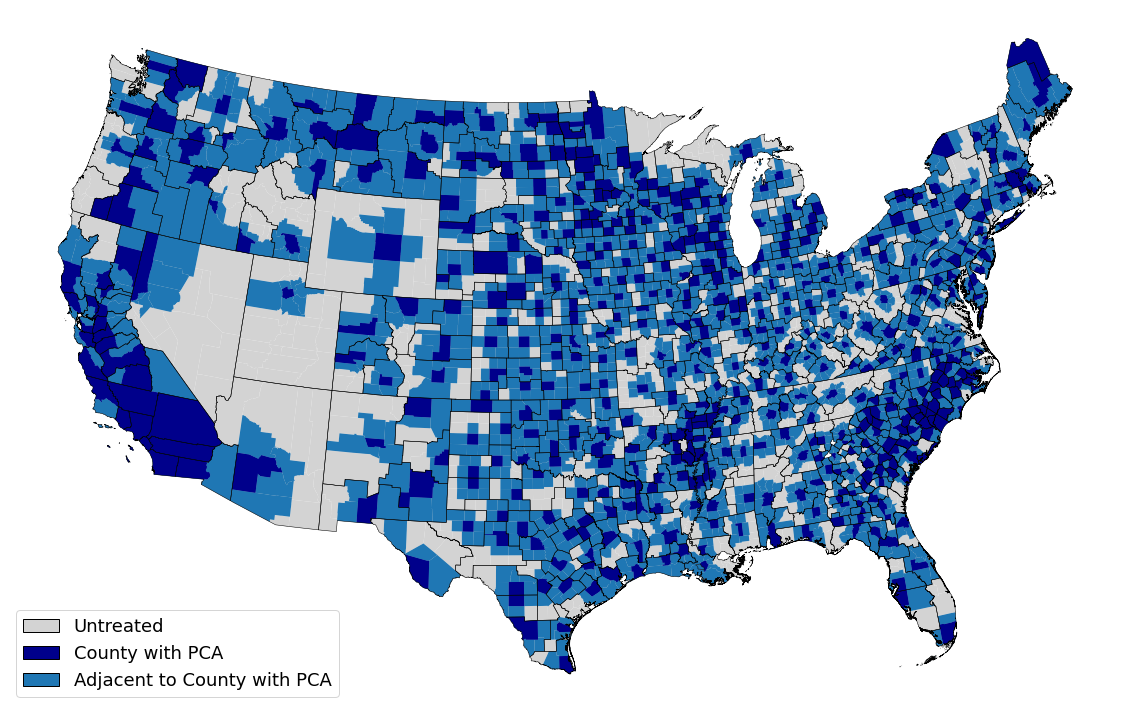

In [19]:
f,a = plt.subplots(figsize=(20,40))
counties.plot(ax=a,color="lightgray")
counties[counties['PCA_area_adj']==1].plot(ax=a,color="C0")
counties[counties['PCA']==1].plot(ax=a,color="darkblue")
# PCAs.plot(ax=a,color="black",marker="*")
coverage_areas.exterior.plot(ax=a,color='black',lw=.5)
a.legend(handles=legend_elements,loc="lower left",fontsize=18)
a.axis('off')
plt.savefig("../../figs/binary_map.png",bbox_inches="tight",dpi=200)

## Comparison

In [20]:
counties['pca_30'] = counties['pca_km']<30
counties['pca_45'] = counties['pca_km']<45
counties['pca_60'] = counties['pca_km']<60
counties['pca_100'] = counties['pca_km']<100

All the different measures

In [22]:
counties[['PCA_area_adj','PCA','pca_30','pca_45','pca_60','pca_100']].mean()

PCA_area_adj    0.725510
PCA             0.176200
pca_30          0.239974
pca_45          0.489809
pca_60          0.660750
pca_100         0.892505
dtype: float64

Treatment measure if PCA areas only compared to adjacent counties

In [23]:
counties[(counties['PCA_area_adj']==1)]['PCA'].mean()

0.24286361576801088

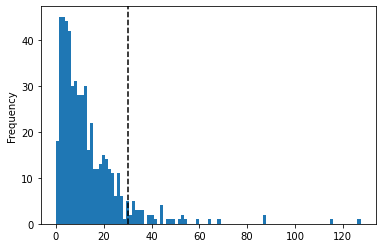

In [24]:
counties[counties['PCA']==1]['pca_km_closest'].plot(kind='hist',bins=100)
plt.axvline(30,color="black",ls="--")

### Table for Figure C.1

In [25]:
def_crosstab = pd.crosstab([counties['PCA'],counties['PCA_area_adj']],counties["pca_km_cat"])
def_crosstab = ((def_crosstab/ np.repeat(def_crosstab.sum(axis=1),5).values.reshape(3,5))*100).round(2)
def_crosstab.columns = ["(0, 30]", "(30, 45]", "(45, 60]", "(60, 100]", "$>$ 100"]
def_crosstab.index = ['No PCA, No Adjacent','Adjacent to PCA County',"PCA County"]
print(def_crosstab.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  (0, 30] &  (30, 45] &  (45, 60] &  (60, 100] &  \$>\$ 100 \\
\midrule
No PCA, No Adjacent    &     0.24 &      4.31 &     13.77 &      49.46 &    32.22 \\
Adjacent to PCA County &    14.06 &     41.65 &     23.76 &      17.30 &     3.23 \\
PCA County             &    91.98 &      5.22 &      1.49 &       0.56 &     0.75 \\
\bottomrule
\end{tabular}



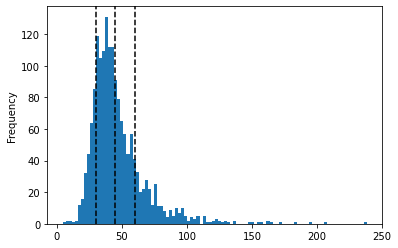

In [26]:
counties[(counties['PCA_area_adj']==1)&(counties['PCA']!=1)]['pca_km_closest'].plot(kind='hist',bins=100)
plt.axvline(30,color="black",ls="--")
plt.axvline(45,color="black",ls="--")
plt.axvline(60,color="black",ls="--")

#### Spatial Comparison

Text(0.5, 1.0, 'PCA w/ Adjacent Counties')

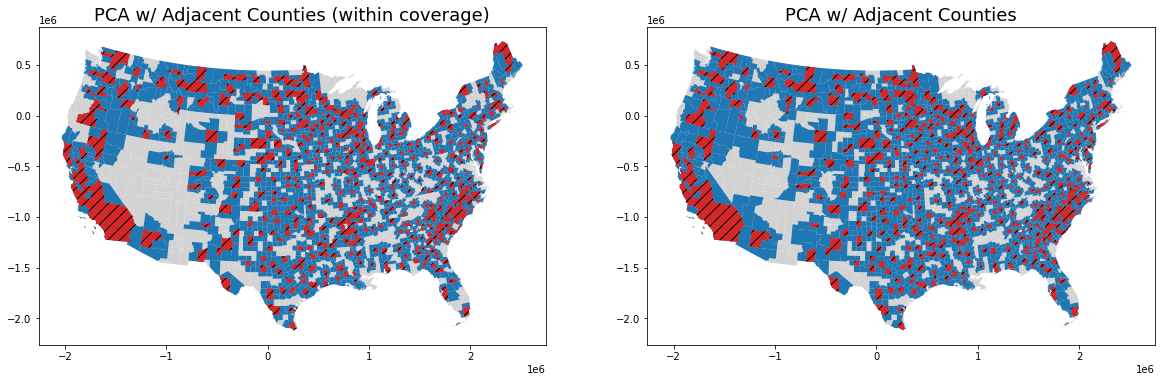

In [27]:
f,a = plt.subplots(1,2,figsize=(20,40))
counties.plot(ax=a[0],color="lightgray")
counties[counties['PCA_area_adj']==1].plot(ax=a[0],color="C0")
counties[counties['PCA']==1].plot(ax=a[0],color="C3",hatch="//")
a[0].set_title("PCA w/ Adjacent Counties (within coverage)",fontsize=18)

counties.plot(ax=a[1],color="lightgray")
counties[counties['PCA_adj']==1].plot(ax=a[1],color="C0")
counties[counties['PCA']==1].plot(ax=a[1],color="C3",hatch="//")
a[1].set_title("PCA w/ Adjacent Counties",fontsize=18)


Text(0.5, 1.0, 'PCA, within 100 km')

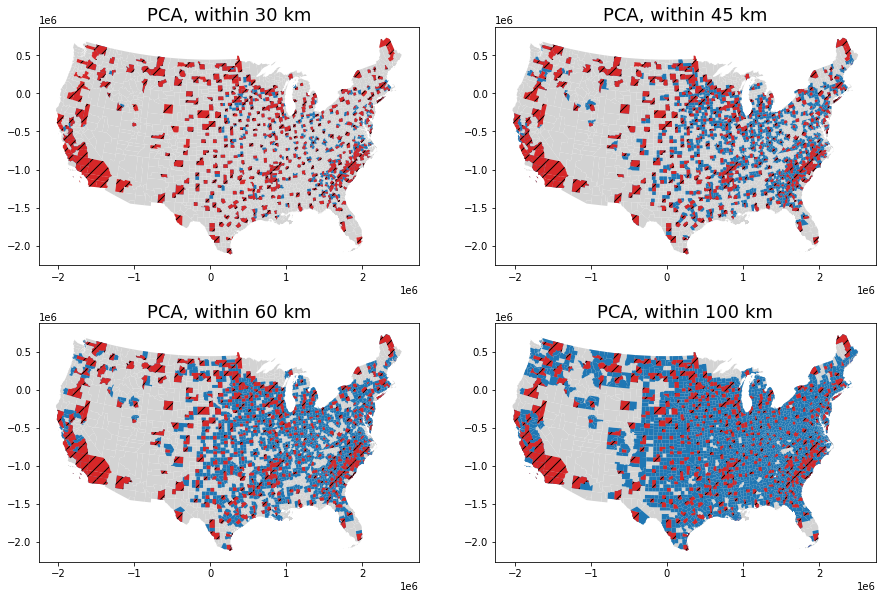

In [28]:
f,a = plt.subplots(2,2,figsize=(15,10))
counties.plot(ax=a[0,0],color="lightgray")
counties[counties['pca_30']==1].plot(ax=a[0,0],color="C0")
counties[counties['PCA']==1].plot(ax=a[0,0],color="C3",hatch="//")
a[0,0].set_title("PCA, within 30 km",fontsize=18)

counties.plot(ax=a[0,1],color="lightgray")
counties[counties['pca_45']==1].plot(ax=a[0,1],color="C0")
counties[counties['PCA']==1].plot(ax=a[0,1],color="C3",hatch="//")
a[0,1].set_title("PCA, within 45 km",fontsize=18)

counties.plot(ax=a[1,0],color="lightgray")
counties[counties['pca_60']==1].plot(ax=a[1,0],color="C0")
counties[counties['PCA']==1].plot(ax=a[1,0],color="C3",hatch="//")
a[1,0].set_title("PCA, within 60 km",fontsize=18)

counties.plot(ax=a[1,1],color="lightgray")
counties[counties['pca_100']==1].plot(ax=a[1,1],color="C0")
counties[counties['PCA']==1].plot(ax=a[1,1],color="C3",hatch="//")
a[1,1].set_title("PCA, within 100 km",fontsize=18)


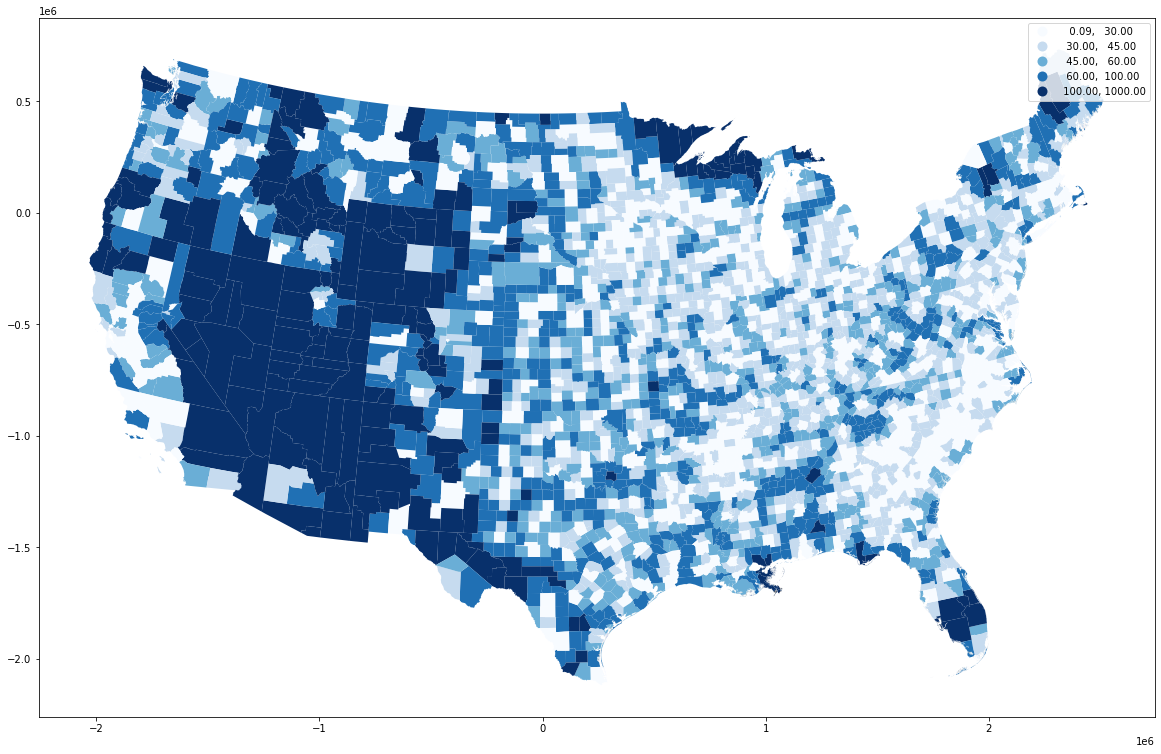

In [29]:
fig, ax = plt.subplots(figsize=(20,40))
counties.plot(ax=ax,column="pca_km_closest",cmap="Blues",classification_kwds=dict(bins=[30,45,60,100,1000]),legend=True,scheme="User_Defined")
plt.show()

## Write out Data

In [31]:
clean_data_dir = "C:/Users/jhtchns2/Dropbox/work/farm-credit/replication_data/clean_data/"


In [32]:
counties['FIPS_state'] =  counties['FIPS'].apply(lambda x: str(x).zfill(5)[:2]).astype(int)

state_names = counties[['FIPS_state','STATENAM']]

state_names.columns = ['FIPS_state','state_name']

state_names.to_csv("state_names.csv",index=False)

In [33]:
PCA_info = \
counties[['FIPS','lat','lon','pca_id','PCA','pca_km','pca_km_closest','pca_km_cat','pca_km_cat_no',
       'PCA_adj', 'PCA_area_adj', 'pca_30', 'pca_45', 'pca_60', 'pca_100']]


PCA_info.to_csv(clean_data_dir+"PCA_info.csv",index=False)